In [1]:
import geopandas as gpd
from osmnx.distance import nearest_nodes
import osmnx as ox
import numpy as np
import matplotlib.pyplot as plt

predio = "7031209006"
gdf_lots = gpd.read_file("../data/processed/predios.geojson", crs="EPSG:4326")
gdf_lots = gdf_lots.loc[gdf_lots['CLAVE_LOTE'] == predio]
gdf_denue = gpd.read_file("../data/processed/denue.geojson", crs="EPSG:4326")

In [2]:
WALK_RADIUS = 1609.34
SECTORS = ['comercio', 'servicios', 'salud', 'educacion']
decay_rate = 0.1

gdf_lots_buffered = gdf_lots.to_crs('EPSG:3043').set_index('CLAVE_LOTE')
gdf_lots_buffered['geometry'] = gdf_lots_buffered.geometry.buffer(WALK_RADIUS)
gdf_denue = gdf_denue.loc[gdf_denue.intersects(gdf_lots_buffered.to_crs('EPSG:4326').unary_union)]
gdf_denue = gdf_denue.loc[gdf_denue['sector'].isin(SECTORS)]

<Axes: >

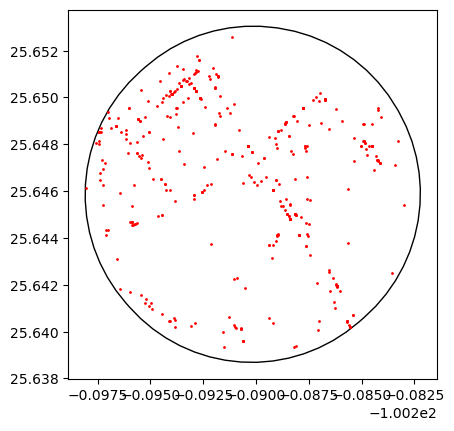

In [3]:
fig, ax = plt.subplots()
gdf_lots_buffered.to_crs('EPSG:4326').plot(ax=ax, color='none', edgecolor='black')
gdf_denue.plot(ax=ax, markersize=1, color='red')

In [4]:
# Get pedestrian network
G = ox.graph_from_polygon(gdf_lots_buffered.to_crs('EPSG:4326').unary_union, network_type='walk')
centroid = gdf_lots.geometry.centroid
start_node = nearest_nodes(G, X=centroid.x.mean(), Y=centroid.y.mean())
start_node

/var/folders/yd/71__64q967d7gl413c68q10m0000gp/T/ipykernel_13752/1829525046.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = gdf_lots.geometry.centroid


1145258092

In [19]:
def calculate_nearest_node(row):
  return nearest_nodes(G, X=row.geometry.centroid.x, Y=row.geometry.centroid.y)


def calculate_walking_time(row):
  length = sum(ox.utils_graph.get_route_edge_attributes(G, row['path'], 'length'))
  # Convert length to time if needed, assuming average walking speed
  walking_speed_m_per_s = 1.4  # Roughly 5 km/h
  walking_time_s = length / walking_speed_m_per_s
  return walking_time_s / 60  # Convert to minutes


def get_paths(row):
  try:
    shortest_path_nodes = ox.distance.shortest_path(G, start_node, row['nearest_node'], weight='length')
    return shortest_path_nodes
  except BaseException:
    return np.nan  # Return NaN if no path found

In [20]:
gdf_denue['nearest_node'] = gdf_denue.apply(calculate_nearest_node, axis=1)
gdf_denue['path'] = gdf_denue.apply(get_paths, axis=1)
gdf_denue['walking_time'] = gdf_denue.apply(calculate_walking_time, axis=1)

/var/folders/yd/71__64q967d7gl413c68q10m0000gp/T/ipykernel_13752/1015302900.py:6: UserWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in a future release. Use the `route_to_gdf` function instead.
  length = sum(ox.utils_graph.get_route_edge_attributes(G, row['path'], 'length'))


In [8]:
within_15_min = gdf_denue.loc[gdf_denue['walking_time'] <= 15]
len(within_15_min), len(gdf_denue)

(436, 438)

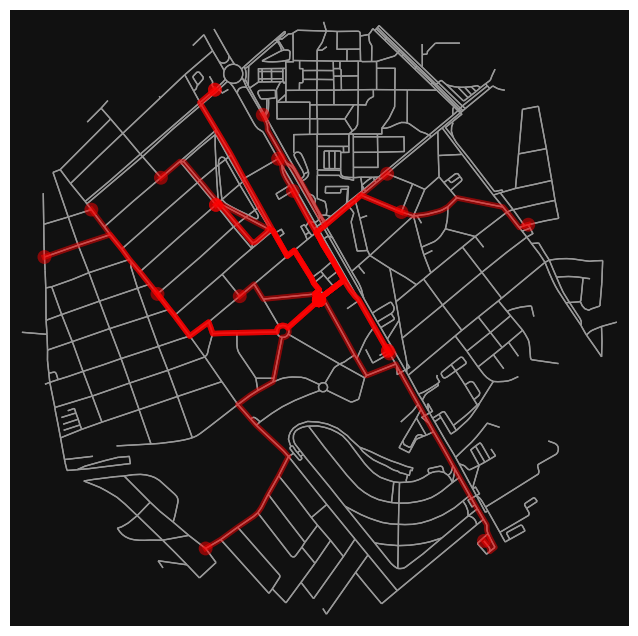

In [9]:
fig, ax = ox.plot_graph_routes(G, within_15_min['path'].tolist()[:20], route_linewidth=4, node_size=0)

In [13]:
sector_weight_mapping = {
  'comercio': 0.5,
  'servicios': 0.5,
  'salud': 0.9,
  'educacion': 1
}
within_15_min['proximity_score'] = np.exp(-decay_rate * within_15_min['walking_time'])
within_15_min['weighted_score'] = within_15_min['proximity_score'] * within_15_min['sector'].map(sector_weight_mapping)

/Users/urielsalazar/miniconda3/envs/atlas-ciudades/lib/python3.11/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [14]:
# Calculate diversity and proximity scores
diversity_scores = within_15_min.groupby('sector')['weighted_score'].sum()
total_diversity_score = diversity_scores.sum()
total_proximity_score = within_15_min['proximity_score'].sum()
final_walkability_score = total_proximity_score + total_diversity_score
total_proximity_score, total_diversity_score, final_walkability_score

(215.21296846636136, 125.20815408394591, 340.42112255030725)

In [15]:
# Count accessible amenities by sector
sector_counts = within_15_min['sector'].value_counts()
sector_counts

sector
comercio     252
servicios    110
educacion     40
salud         34
Name: count, dtype: int64

In [16]:
# Update gdf_lots with adjacency counts
gdf_lots['services_nearby'] = 0
for sector, count in sector_counts.items():
  gdf_lots[f"adj_{sector.lower()}"] = count
  gdf_lots['services_nearby'] += count
gdf_lots

,CLAVE_LOTE,geometry,services_nearby,adj_comercio,adj_servicios,adj_educacion,adj_salud
3700,7031209006,"POLYGON ((-100.29021 25.64569, -100.29036 25.6...",436,252,110,40,34
